In [303]:
import pandas 
import seaborn
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine, Unit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso

Проверим датафрейм на наличие пропусков:

In [304]:
train = pandas.read_csv("/kaggle/input/lab-2-linear-regression/train.csv")
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [305]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2209155,2,2016-05-03 09:03:08,2016-05-03 09:17:12,2,-73.979813,40.752529,-73.982681,40.763680,N,844
1,id0586605,1,2016-01-01 16:40:51,2016-01-01 16:57:32,1,-73.977623,40.746296,-73.968414,40.788933,N,1001
2,id0467144,1,2016-04-24 13:57:03,2016-04-24 14:14:31,1,-73.950699,40.779404,-73.863129,40.768608,N,1048
3,id0989010,2,2016-01-10 17:03:47,2016-01-10 17:16:51,1,-73.984558,40.721802,-73.976753,40.752213,N,784
4,id0580742,1,2016-02-25 17:37:36,2016-02-25 17:49:48,1,-73.967720,40.768742,-73.977173,40.789875,N,732


In [306]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021050 entries, 0 to 1021049
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1021050 non-null  object 
 1   vendor_id           1021050 non-null  int64  
 2   pickup_datetime     1021050 non-null  object 
 3   dropoff_datetime    1021050 non-null  object 
 4   passenger_count     1021050 non-null  int64  
 5   pickup_longitude    1021050 non-null  float64
 6   pickup_latitude     1021050 non-null  float64
 7   dropoff_longitude   1021050 non-null  float64
 8   dropoff_latitude    1021050 non-null  float64
 9   store_and_fwd_flag  1021050 non-null  object 
 10  trip_duration       1021050 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 85.7+ MB


In [307]:
test = pandas.read_csv("/kaggle/input/lab-2-linear-regression/test.csv")
test.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag'],
      dtype='object')

Мы видим, что у тестового набора данных отсутствует столбец "dropoff_datetime", а значит его можно убрать из тренировочного набора данных, так как он не будет доступен при прогнозировании. Это нужно, чтобы тренировочные данные совпадали по структуре с тестовыми.

In [308]:
train = train.drop(columns="dropoff_datetime")

Построим гистограмму длительности поездок для оценки распределения, чтобы понять, есть ли выбросы (аномально длинные или короткие поездки):

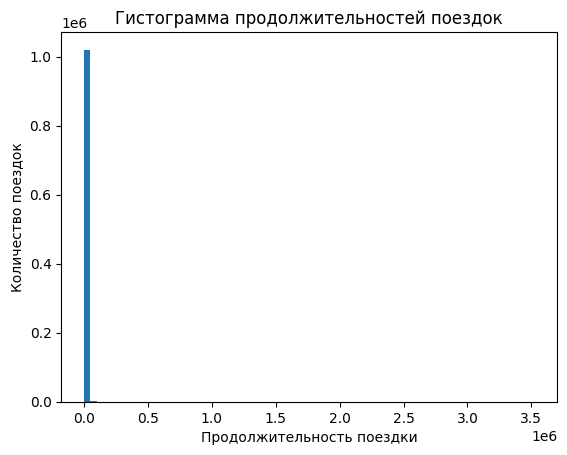

In [309]:
plt.hist(train["trip_duration"], bins=70)
plt.title("Гистограмма продолжительностей поездок")
plt.xlabel('Продолжительность поездки')
plt.ylabel('Количество поездок')
plt.show()

По диаграмме сложно что-либо понять из-за выбросов. Уберем их, использовуя метод IQR (межквартильного размаха) для определения выбросов, чтобы оставить только центральные значения распределения, игнорируя крайние значения:

In [310]:
Q1 = train["trip_duration"].quantile(0.2)
Q3 = train["trip_duration"].quantile(0.85)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
train = train[(train["trip_duration"] >= lower_bound) & (train["trip_duration"] <= upper_bound)]

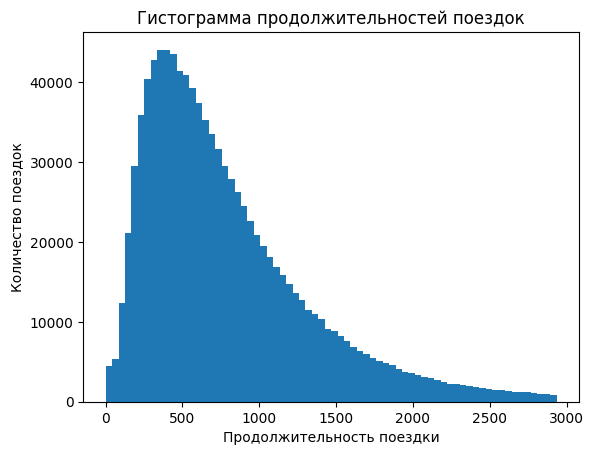

In [311]:
plt.hist(train["trip_duration"], bins=70)
plt.title("Гистограмма продолжительностей поездок")
plt.xlabel('Продолжительность поездки')
plt.ylabel('Количество поездок')
plt.show()

Гистограмма похожа на нормальное распределение, но оно скошенное. Логарифмирование помогает преобразовать скошенное распределение длительности поездок в более нормальное, чтобы модель лучше справлялась с вариацией длительностей поездок, особенно с более длинными:

In [312]:
train["trip_duration"] = np.log(train['trip_duration'] + 1)

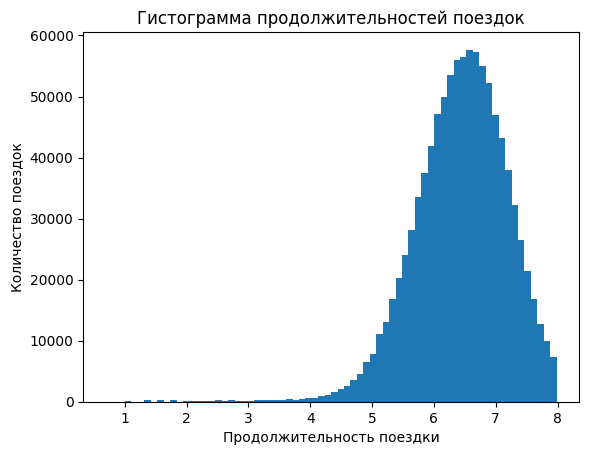

In [313]:
plt.hist(train["trip_duration"], bins=70)
plt.title("Гистограмма продолжительностей поездок")
plt.xlabel('Продолжительность поездки')
plt.ylabel('Количество поездок')
plt.show()

Посчитаем корреляцию между параметрами и таргетом, используя функцию "corr()".
Значения корреляции будем интерпретировать следующим образом:
- 0.0–0.2: Очень слабая или отсутствующая корреляция.
- 0.2–0.4: Слабая корреляция.
- 0.4–0.6: Умеренная корреляция.
- 0.6–0.8: Сильная корреляция.
- 0.8–1.0: Очень сильная корреляция.

# vendor_id

In [314]:
correlation = train["trip_duration"].corr(train["vendor_id"])
print(f"Корреляция между vendor_id и trip_duration: {correlation}")

Корреляция между vendor_id и trip_duration: 0.010747487398213145


Корреляция в районе 0.01 фактически не дает информации о связи между переменными, поэтому удаление "vendor_id" как признака из данных для модели оправдано.

In [315]:
train = train.drop(columns="vendor_id")

# passenger_count

In [316]:
correlation = train["trip_duration"].corr(train["passenger_count"])
print(f"Корреляция между passenger_count и trip_duration: {correlation}")

Корреляция между passenger_count и trip_duration: 0.01690432908680485


Ситуация аналогична "vendor_id", поэтому снова удаляем признак.

In [317]:
train = train.drop(columns="passenger_count")

# store_and_fwd_flag

In [318]:
correlation = train["trip_duration"].corr(train["store_and_fwd_flag"].apply(lambda x: 1 if x == 'Y' else 0))
print(f"Корреляция между store_and_fwd и trip_duration: {correlation}")

Корреляция между store_and_fwd и trip_duration: 0.011103814432037005


Снова корреляция близка к 0 => признак не имеет линейной зависимости с целевой переменной и его можно безопасно удалить:

In [319]:
train = train.drop(columns="store_and_fwd_flag")

In [320]:
train

,id,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
0,id2209155,2016-05-03 09:03:08,-73.979813,40.752529,-73.982681,40.763680,6.739337
1,id0586605,2016-01-01 16:40:51,-73.977623,40.746296,-73.968414,40.788933,6.909753
2,id0467144,2016-04-24 13:57:03,-73.950699,40.779404,-73.863129,40.768608,6.955593
3,id0989010,2016-01-10 17:03:47,-73.984558,40.721802,-73.976753,40.752213,6.665684
4,id0580742,2016-02-25 17:37:36,-73.967720,40.768742,-73.977173,40.789875,6.597146
...,...,...,...,...,...,...,...
1021045,id1753868,2016-03-25 07:11:49,-73.955032,40.777328,-74.006203,40.749424,7.156177
1021046,id2204747,2016-02-16 18:01:45,-73.973618,40.763920,-73.983849,40.749874,6.726233
1021047,id3043606,2016-01-26 19:22:29,-74.006195,40.734283,-73.949608,40.785282,7.159292
1021048,id1458584,2016-01-19 11:53:47,-73.962341,40.767323,-73.969757,40.768669,5.966147


# pickup_datetime

Так как данный формат данных не даёт ничего полезного, разделим столбец "pickup_datetime" на столбцы c месяцем, днем недели и временем суток.

# Месяц

Так как месяц - категориальная величина, я воспользуюсь простейшим методом - One-Hot Encoding, чтобы модель более точно предсказывала данные на основании месяцев.

In [321]:
time = pandas.to_datetime(train['pickup_datetime']).reset_index()

In [322]:
time['month'] = time['pickup_datetime'].dt.month
time['year'] = time['pickup_datetime'].dt.year
time.describe()

,index,pickup_datetime,month,year
count,1.003045e+06,1003045,1.003045e+06,1003045.0
mean,5.104716e+05,2016-04-01 04:22:27.145435136,3.508768e+00,2016.0
min,0.000000e+00,2016-01-01 00:00:17,1.000000e+00,2016.0
25%,2.551540e+05,2016-02-17 12:13:19,2.000000e+00,2016.0
50%,5.105020e+05,2016-04-01 08:33:24,4.000000e+00,2016.0
75%,7.657450e+05,2016-05-14 22:00:29,5.000000e+00,2016.0
max,1.021049e+06,2016-06-30 23:59:39,6.000000e+00,2016.0
std,2.947697e+05,NaN,1.680351e+00,0.0


Создадим колонку для каждого месяца:

In [323]:
train['pickup_datetime'] = pandas.to_datetime(train['pickup_datetime'])

In [324]:

train['month'] = train['pickup_datetime'].dt.month
train = pandas.get_dummies(train, columns=['month'], prefix='month')
train

,id,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,month_1,month_2,month_3,month_4,month_5,month_6
0,id2209155,2016-05-03 09:03:08,-73.979813,40.752529,-73.982681,40.763680,6.739337,False,False,False,False,True,False
1,id0586605,2016-01-01 16:40:51,-73.977623,40.746296,-73.968414,40.788933,6.909753,True,False,False,False,False,False
2,id0467144,2016-04-24 13:57:03,-73.950699,40.779404,-73.863129,40.768608,6.955593,False,False,False,True,False,False
3,id0989010,2016-01-10 17:03:47,-73.984558,40.721802,-73.976753,40.752213,6.665684,True,False,False,False,False,False
4,id0580742,2016-02-25 17:37:36,-73.967720,40.768742,-73.977173,40.789875,6.597146,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021045,id1753868,2016-03-25 07:11:49,-73.955032,40.777328,-74.006203,40.749424,7.156177,False,False,True,False,False,False
1021046,id2204747,2016-02-16 18:01:45,-73.973618,40.763920,-73.983849,40.749874,6.726233,False,True,False,False,False,False
1021047,id3043606,2016-01-26 19:22:29,-74.006195,40.734283,-73.949608,40.785282,7.159292,True,False,False,False,False,False
1021048,id1458584,2016-01-19 11:53:47,-73.962341,40.767323,-73.969757,40.768669,5.966147,True,False,False,False,False,False


# Дни недели

In [325]:

train['day_of_week'] = train['pickup_datetime'].dt.day_of_week
train = pandas.get_dummies(train, columns=['day_of_week'], prefix='day_of_week')
train = train.astype({col: 'int' for col in train.select_dtypes(include='bool').columns})
train

,id,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,month_1,month_2,month_3,month_4,month_5,month_6,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,id2209155,2016-05-03 09:03:08,-73.979813,40.752529,-73.982681,40.763680,6.739337,0,0,0,0,1,0,0,1,0,0,0,0,0
1,id0586605,2016-01-01 16:40:51,-73.977623,40.746296,-73.968414,40.788933,6.909753,1,0,0,0,0,0,0,0,0,0,1,0,0
2,id0467144,2016-04-24 13:57:03,-73.950699,40.779404,-73.863129,40.768608,6.955593,0,0,0,1,0,0,0,0,0,0,0,0,1
3,id0989010,2016-01-10 17:03:47,-73.984558,40.721802,-73.976753,40.752213,6.665684,1,0,0,0,0,0,0,0,0,0,0,0,1
4,id0580742,2016-02-25 17:37:36,-73.967720,40.768742,-73.977173,40.789875,6.597146,0,1,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021045,id1753868,2016-03-25 07:11:49,-73.955032,40.777328,-74.006203,40.749424,7.156177,0,0,1,0,0,0,0,0,0,0,1,0,0
1021046,id2204747,2016-02-16 18:01:45,-73.973618,40.763920,-73.983849,40.749874,6.726233,0,1,0,0,0,0,0,1,0,0,0,0,0
1021047,id3043606,2016-01-26 19:22:29,-74.006195,40.734283,-73.949608,40.785282,7.159292,1,0,0,0,0,0,0,1,0,0,0,0,0
1021048,id1458584,2016-01-19 11:53:47,-73.962341,40.767323,-73.969757,40.768669,5.966147,1,0,0,0,0,0,0,1,0,0,0,0,0


# Время суток

In [326]:
train['hour'] = train['pickup_datetime'].dt.hour

train['morning'] = train['hour'].between(6, 12).astype(int)
train['day'] = train['hour'].between(13, 17).astype(int)
train['evening'] = train['hour'].between(18, 23).astype(int)
train['night'] = train['hour'].between(0, 5).astype(int)

train = train.drop(columns=['hour'])
train = train.drop(columns=['pickup_datetime'])
train

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,month_1,month_2,month_3,month_4,...,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,morning,day,evening,night
0,id2209155,-73.979813,40.752529,-73.982681,40.763680,6.739337,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,id0586605,-73.977623,40.746296,-73.968414,40.788933,6.909753,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,id0467144,-73.950699,40.779404,-73.863129,40.768608,6.955593,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
3,id0989010,-73.984558,40.721802,-73.976753,40.752213,6.665684,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,id0580742,-73.967720,40.768742,-73.977173,40.789875,6.597146,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021045,id1753868,-73.955032,40.777328,-74.006203,40.749424,7.156177,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
1021046,id2204747,-73.973618,40.763920,-73.983849,40.749874,6.726233,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
1021047,id3043606,-74.006195,40.734283,-73.949608,40.785282,7.159292,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1021048,id1458584,-73.962341,40.767323,-73.969757,40.768669,5.966147,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0


# Расстояние

Используюя координаты точек старта и начала мы можем вычислить примерное расстояние от точки старта, до точки финиша.    Логично предположить, что чем больше будет расстояние, тем дольше будет поездка. Для рассчёта расстояния воскользуемся формулой Хаверсина:

In [328]:
train['haversine'] = train.apply(lambda row: haversine((row['pickup_latitude'], row['pickup_longitude']), 
                                                     (row['dropoff_latitude'], row['dropoff_longitude']), 
                                                     unit=Unit.KILOMETERS), axis=1)
train['haversine'] = np.log(train['haversine'] + 1)

(-2.0, 50.0)

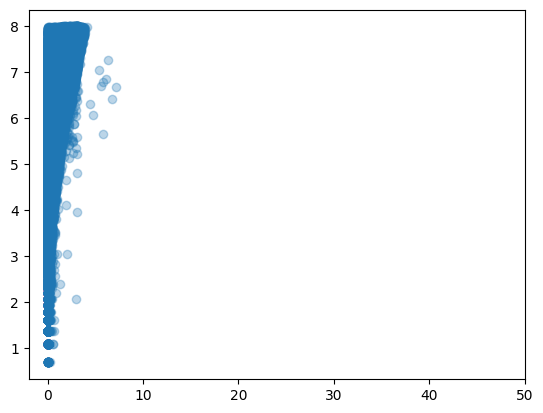

In [329]:
plt.scatter(train['haversine'], train['trip_duration'], alpha=0.3)
plt.xlim(-2, 50)

In [330]:
train = train.drop(columns=['pickup_latitude'])
train = train.drop(columns=['pickup_longitude'])
train = train.drop(columns=['dropoff_latitude'])
train = train.drop(columns=['dropoff_longitude'])
train = train.drop(columns=['id'])
train

,trip_duration,month_1,month_2,month_3,month_4,month_5,month_6,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,morning,day,evening,night,haversine
0,6.739337,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0.816775
1,6.909753,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1.758551
2,6.955593,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,2.136660
3,6.665684,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1.491751
4,6.597146,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1.247339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021045,7.156177,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1.842198
1021046,6.726233,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1.023810
1021047,7.159292,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,2.129143
1021048,5.966147,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0.496047


In [331]:
train['haversine'].corr(train['trip_duration'])

0.7522286023354674

# Разбиение данных и подбор модели

In [ ]:
Y = data['trip_duration']
X = data.drop(columns=['trip_duration'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=52)


ridge_params = {'alpha': np.logspace(-3, 2, 10)}
lasso_params = {'alpha': np.logspace(-3, 2, 10)}
ridge = Ridge()
ridge_search = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_search.fit(X_train, Y_train)
ridge_best = ridge_search.best_estimator_


lasso = Lasso()
lasso_search = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_search.fit(X_train, Y_train)
lasso_best = lasso_search.best_estimator_


for model, name in zip([LinearRegression(), ridge_best, lasso_best], ['Linear', 'Ridge', 'Lasso']):
    model.fit(X_train, Y_train)
    result = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(Y_test, result))
    print(f'RMSE for {name}: {rmse:.4f}')

Мы видим, что разные модели дали примерно одинаковый результат, поэтому я решил оставить Ridge

# Подготавливаем тестовые данные

In [ ]:

test = test.drop(columns="vendor_id")
test = test.drop(columns="passenger_count")
test = test.drop(columns="store_and_fwd_flag")
test['pickup_datetime'] = pandas.to_datetime(test['pickup_datetime'])

test['month'] = test['pickup_datetime'].dt.month
test = pandas.get_dummies(test, columns=['month'], prefix='month')

test['day_of_week'] = test['pickup_datetime'].dt.day_of_week
test = pandas.get_dummies(test, columns=['day_of_week'], prefix='day_of_week')
test = test.astype({col: 'int' for col in test.select_dtypes(include='bool').columns})

test['hour'] = test['pickup_datetime'].dt.hour

test['morning'] = test['hour'].between(6, 12).astype(int)
test['day'] = test['hour'].between(13, 17).astype(int)
test['evening'] = test['hour'].between(18, 23).astype(int)
test['night'] = test['hour'].between(0, 5).astype(int)

test = test.drop(columns=['hour'])
test = test.drop(columns=['pickup_datetime'])

test['haversine'] = test.apply(lambda row: haversine((row['pickup_latitude'], row['pickup_longitude']), 
                                                     (row['dropoff_latitude'], row['dropoff_longitude']), 
                                                     unit=Unit.KILOMETERS), axis=1)
test['haversine'] = np.log(test['haversine'] + 1)
answer = pandas.DataFrame()
answer['id'] = test['id']

test = test.drop(columns=['pickup_latitude'])
test = test.drop(columns=['pickup_longitude'])
test = test.drop(columns=['dropoff_latitude'])
test = test.drop(columns=['dropoff_longitude'])
test = test.drop(columns=['id'])

test

In [ ]:

answer['trip_duration'] = np.exp(ridge_search.predict(test)) + 1
answer

In [ ]:
answer.to_csv("answer.csv", index=False)